# Point Pattern Analysis

#### The motivation of this project is to explore geographical point patterns to probe:
-What does the pattern look like?<br>
-What is the nature of the distribution?<br> 
-Is there a structure to the distribution? And more importantly, are the points clustered is a specific way?<br>
-Deeper insights that can help highlight the underlying reason for said distribution; why events happen at specific locations and not others?<br>


In [1]:
#Import the necessary libraries

import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pointpats import centrography
from matplotlib.patches import Ellipse,Circle,Polygon,Rectangle
from pointpats import centrography
from pygeodesy import sphericalTrigonometry as st
from descartes import PolygonPatch
import libpysal
from pointpats import QStatistic
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

### Data description 
Sourced from [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67)

Dataframe contains information of 10K photographs in the city of Tokyo pertaining to:<br>
-user_id: Unique user identifier<br>
-latitude & longitude along with a transformed version in Pseudo Mercator (x&y)<br>
-timestamp of photo/video<br>
-URL of the photo/video<br>

In [3]:
#Read data
df = pd.read_csv('../tokyo_photographs_dataset.csv')
df.head()


,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
user_id                 10000 non-null object
longitude               10000 non-null float64
latitude                10000 non-null float64
date_taken              10000 non-null object
photo/video_page_url    10000 non-null object
x                       10000 non-null float64
y                       10000 non-null float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


### Visualization

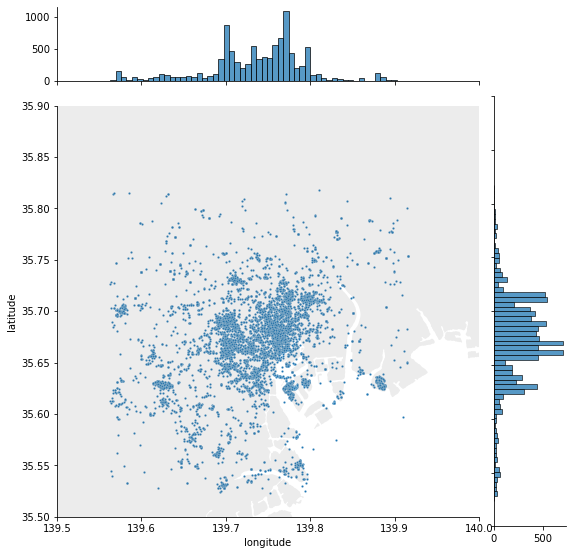

In [5]:
#Read the tokyo shape file
tokyo_map = gpd.read_file('../gadm36_JPN_shp/gadm36_JPN_0.shp')

#Scatter plot of two variables (lat & long) along with univariate and bivariate graphs
joint_axes = sns.jointplot(x='longitude', y='latitude', data=df, s=5, height=8, 
                           marginal_ticks=True,alpha=1)

#Set x & y limits within the photograph boundaries
joint_axes.ax_joint.set_xlim([139.5,140])
joint_axes.ax_joint.set_ylim([35.5,35.9])

#Plot map on the axes of the joint plot
tokyo_map.plot(ax=joint_axes.ax_joint,color='grey',alpha=0.15)


#### Key observations from visualization
-Visualization provides good detail; photographs seem to concentrated in certain clusters/regions of the city more than others.<br>-The cluttered nature of the photographs makes it hard to discern an underlying pattern; a simple choropleth of 2D hexbins or KDE plots would help distinguish popular regions from the rest.

### Density Plots

#### Hexbins

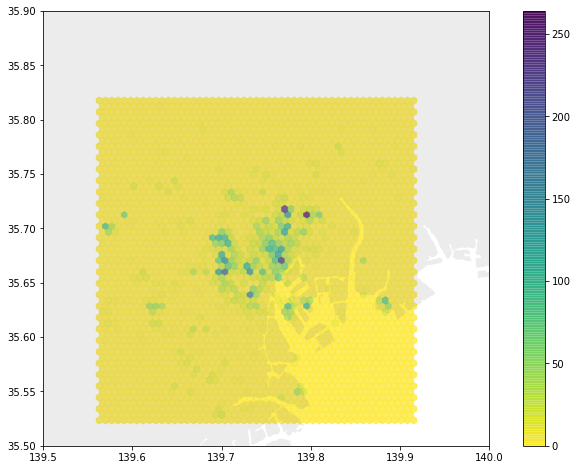

In [6]:
#Setup figure and axes
fig,ax = plt.subplots(1,figsize=(12,8))
hexbin_axes = ax.hexbin(df['longitude'],df['latitude'],
                        gridsize=50,linewidths=0.5,alpha=0.75,cmap='viridis_r')
ax.set_xlim([139.5,140])
ax.set_ylim([35.5,35.9])

#Overlay geographic boundaries map
tokyo_map.plot(ax=ax,alpha=0.15,color='grey')
plt.colorbar(hexbin_axes)



#### Kernel Density Estimate (KDE) Plots

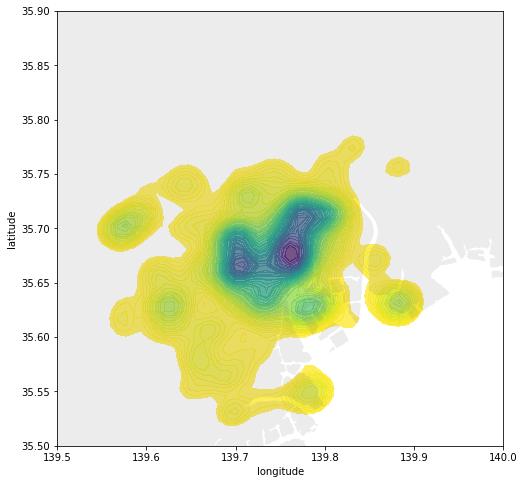

In [7]:
#Setup figure and axes
fig,ax = plt.subplots(1,figsize=(12,8))
sns.kdeplot(df['longitude'],df['latitude'],gridsize=50,linewidths=0.5,
            ax=ax,alpha=0.75,cmap='viridis_r',shade=True,n_levels=50)
ax.set_xlim([139.5,140])
ax.set_ylim([35.5,35.9])

#Overlay geographic boundaries map
tokyo_map.plot(ax=ax,alpha=0.15,color='grey')
plt.show()

Using hexbin and KDE plots helps visualize high density regions with more photographs easily. While the underlying pattern is still not immediately apparent, these plots suitably demonstrate the existence of high denisty regions and provide a quick way to contrast varying density regions. While hexbins divide the map into discrete regions, KDEs provide a more continuous distribution.

### Centrography

Centrography is the analysis of centrality in a point pattern. Specifically, we're concerned with the tendency of "center of mass" of a point pattern, the dispersion from the central point, and the extent measured by the size of different shapes enveloping the points.



#### Tendency & Dispersion
The tendency is measured by identifying the mean and median of the point pattern. Dispersion from mean is measured by standard distance (similar to standard deviation) and by the standard deviation ellipse (which quantifies distance of spread and direction).

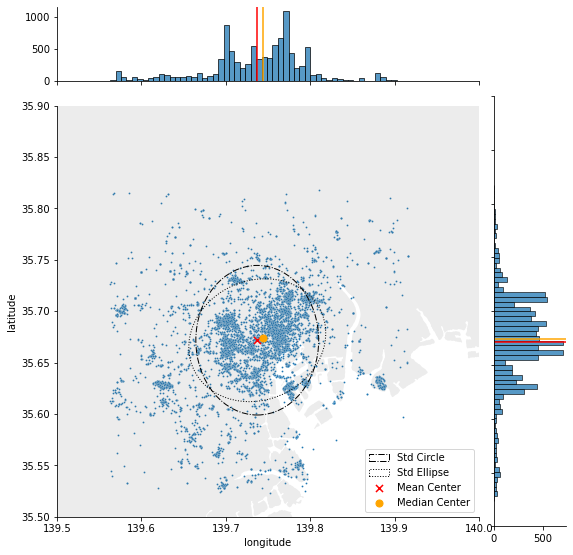

In [9]:
#Calculate the central points of this distribution
mean_center = centrography.mean_center(df[['longitude','latitude']])
median_center = centrography.euclidean_median(df[['longitude','latitude']])

#Calculate the standard distance and standard deviational ellipse of this distribution
std_dist = centrography.std_distance(df[['longitude','latitude']])
std_dist_km = centrography.std_distance(df[['x','y']])
std_circle = Circle(mean_center,std_dist,fill=False,ls='-.',label='Std Circle')
major,minor,rotation = centrography.ellipse(df[['longitude','latitude']])
std_ellipse = Ellipse(xy=mean_center,width=major*2,height=minor*2,
                      angle = -np.rad2deg(rotation),fill=False,ls=':',label='Std Ellipse')

#Scatter plot of two variables (lat & long) along with univariate and bivariate graphs
joint_axes = sns.jointplot(x='longitude', y='latitude', data=df, s=3.5, height=8, 
                           marginal_ticks=True,alpha=1)

#Set x & y limits within the photograph boundaries
joint_axes.ax_joint.set_xlim([139.5,140])
joint_axes.ax_joint.set_ylim([35.5,35.9])

#Plot map on the axes of the joint plot
tokyo_map.plot(ax=joint_axes.ax_joint,color='grey',alpha=0.15)

#Plot the mean center
joint_axes.ax_joint.scatter(*mean_center,color='red',marker='x',s=50,alpha=1,label='Mean Center')
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')

#Plot the median center
joint_axes.ax_joint.scatter(*median_center,color='orange',marker='o',s=50,alpha=1,label='Median Center')
joint_axes.ax_marg_x.axvline(median_center[0], color='orange')
joint_axes.ax_marg_y.axhline(median_center[1], color='orange')

#Plot standard circle and standard deviational ellipse
joint_axes.ax_joint.add_patch(std_circle)
joint_axes.ax_joint.add_patch(std_ellipse)

#Allow legend
joint_axes.ax_joint.legend(loc='lower right')
plt.show()


#### Extent
This centrography measure characterizes the extent of a point cloud. Four shapes are useful, and reflect varying levels of how “tightly” they bind the pattern.

*Convex hull*- convex shape that encloses the point pattern. This can be imagined as the shape made by rolling a really large circle (radius -> infinity) around the pattern shape.<br>
*Alpha shape*- "tighter" variation of the convex hull. This can be imagined as the shape made by rolling very tiny circles around the pattern shape; the radius of such a circle which can enclose all the points without looping across a point is the alpha radius, and these circles are called bounding circles.<br>
*Minimum bounding rectangle*- tightest rectangle that can be drawn to enclose the point pattern<br>
*Minimum bounding circle*- tightest circle that can be drawn to enclose the point pattern<br>



In [ ]:
#Filtering for a single user to make the visualization simpler and more meaningful
user_df = df[df['user_id']=='95795770@N00']
coordinates = user_df[['longitude','latitude']].values

#Setup scatter plot for user points along with the Tokyo map
fig,ax = plt.subplots(1,figsize=(12,8))
ax.scatter(*coordinates.T,label='User locations',s=5)
ax.set_xlim([139.5,140])
ax.set_ylim([35.4,35.9])
tokyo_map.plot(ax=ax,color='grey',alpha=0.15)

#Convex hull vertices=> corners of the point patterns
convex_hull_vertices = centrography.hull(coordinates)
convex_hull = Polygon(convex_hull_vertices,closed=True,edgecolor='black',facecolor='none',fill=False,ls=':',
                      label='Convex hull')
ax.add_patch(convex_hull)


#Calculate the alpha_shape, alpha (radius of bounding circle) and bounding circles respectively
alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(coordinates, return_circles=True)
alpha_poly_patch = PolygonPatch(alpha_shape,edgecolor='tab:green',facecolor='green',
                                alpha=0.2,label = 'Tighest single alpha shape')
ax.add_patch(alpha_poly_patch)

#Minimum bounding rectangle
min_rect_vertices = centrography.minimum_bounding_rectangle(coordinates)
min_rect_width = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_height = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_patch = Rectangle(min_rect_vertices[0:2], width = min_rect_width,
                           height = min_rect_height, edgecolor='goldenrod', facecolor='none', 
                           linestyle='dashed', linewidth=2, label='Min Bounding Rectangle')
ax.add_patch(min_rect_patch)

#Minimum bounding circle
(center_x, center_y), radius = centrography.minimum_bounding_circle(coordinates)
circle_patch = Circle((center_x,center_y),radius=radius,edgecolor='red', facecolor='none', 
                      linewidth=2,label='Min Bounding Circle')


ax.legend(loc='lower right')

### Quantifying Randomness
Beyond understanding centrality and dispersion, it is necessary to quantify the randomness of a point pattern. Are the points clustered around a given region or evenly distributed? For this we'll explore the concepts of quadrant statistics and Ripley's alphabet of functions.<br>
Quandrant statistics relies on the idea of splitting the point pattern area into uniform quadrants and measuring the difference in the number and "eveness" of points in each smaller area. In contrast, Ripley's functions work by calculating the distance between points in a point pattern.<br>

To represent these ideas, it would help to create a random point pattern using a Poisson process; check function *generate_possion_points* below. In the Q-statistic we check for p-values in a chi-squared test (which compares how likely this distribution is if the cell counts are uniform) with the expectation that statisitcally significant p-values (<0.05) would be indicative of a non-random point process.

In [ ]:
def generate_poisson_points(x_min=0,x_max=1,y_min=0,y_max=1,_lambda=1500,seed=42):
    """Returns tuple of arrays x&y coordinates of poisson process
    Args:
        x_min,x_max: Min and max x-coordinates of the plane
        y_min,y_max: Min and max y-coordinates of the plane
        _lambda: intensity/mean density of the Poisson process"""
    
    x_delta = x_max-x_min
    y_delta = y_max-y_min
    area = x_delta*y_delta
    
    np.random.seed(seed)
    n = np.random.poisson(_lambda*area) #Number of poisson points
    x = x_delta*(np.random.uniform(0,1,n))+x_min
    y = y_delta*(np.random.uniform(0,1,n))+y_min
    return np.stack([x,y],axis=1)


poisson_coordinates = generate_poisson_points(139.5,140,35.4,35.9)

fig,ax = plt.subplots(1,figsize=(12,8))
ax.scatter(*coordinates.T,label='User locations',s=15)
ax.set_xlim([139.5,140])
ax.set_ylim([35.4,35.9])
tokyo_map.plot(ax=ax,color='grey',alpha=0.15)
ax.scatter(*poisson_coordinates.T,label='Poisson points',marker='x',color='tab:orange',alpha=0.75)
ax.legend(loc='lower right')

In [ ]:
qstat = QStatistic(coordinates)
qstat.plot(title='Quadrant Count- User Location Coordinates')
print('User location qstat p-value: {:0.2f}'.format(qstat.chi2_pvalue))

qstat_poisson = QStatistic(poisson_coordinates)
qstat_poisson.plot(title='Quadrant Count- Poisson Pattern')
print('Poisson pattern qstat p-value: {:0.2f}'.format(qstat_poisson.chi2_pvalue))

From the above plots and their respective chi-squared test p-value it's evident that the poisson pattern has a very random pattern, while the user location coordinates have a p-value ~0. This helps build some perspective on identifying statistically significant non-random point processes as shown above.

The qstat test, however, has some disadvantages as well. Given that the process relies on overlaying a regular grid over the point pattern, random patterns in a very specific shape can provide misleading results as well. In the steps below we'll simulate the same random pattern within the alpha shape of the user coordinates and illustrate this idea.

In [ ]:
def generate_possion_points_within_area(polygon_patch,x_min=0,x_max=1,y_min=0,y_max=1,_lambda=1500):
    """Returns tuple of arrays x&y coordinates of poisson process within a polygon patch
    Args:
        x_min,x_max: Min and max x-coordinates of the plane
        y_min,y_max: Min and max y-coordinates of the plane
        polygon_patch: Polygon within the coordinate grid to check for poisson points
        _lambda: intensity/mean density of the Poisson process"""
    poisson_coordinates = generate_poisson_points(x_min,x_max,y_min,y_max,_lambda,seed=0)
    transformed_points = polygon_patch.get_transform().transform(poisson_coordinates) #check for points in the alpha shape
    return poisson_coordinates[polygon_patch.contains_points(transformed_points)]

alpha_poisson_coordinates = generate_possion_points_within_area(alpha_poly_patch,139.5,140,35.4,35.9,5000)

fig,ax = plt.subplots(1,figsize=(12,8))

#Calculate the alpha_shape, alpha (radius of bounding circle) and bounding circles respectively
alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(coordinates, return_circles=True)
alpha_poly_patch = PolygonPatch(alpha_shape,edgecolor='tab:green',facecolor='green',
                                alpha=0.2,label = 'Tighest single alpha shape')
ax.add_patch(alpha_poly_patch)
ax.scatter(*coordinates.T,label='User locations',s=15)
ax.set_xlim([139.5,140])
ax.set_ylim([35.4,35.9])
tokyo_map.plot(ax=ax,color='grey',alpha=0.15)
ax.scatter(*alpha_poisson_coordinates.T,label='Poisson points',marker='x',color='orange',alpha=1)
ax.legend(loc='lower right')


In [ ]:
qstat = QStatistic(coordinates)
qstat.plot(title='Quadrant Count- User Location Coordinates')
print('User location qstat p-value: {:0.8f}'.format(qstat.chi2_pvalue))

qstat_alpha_poisson = QStatistic(alpha_poisson_coordinates)
qstat_alpha_poisson.plot(title='Quadrant Count- Alpha Shape Poisson Pattern')
print('Poisson pattern inside the alpha shape qstat p-value: {:0.8f}'.format(qstat_alpha_poisson.chi2_pvalue))

From the above plots and their respective chi-squared test p-value it's evident that the poisson pattern in the alpha shape, although random has a lower than threshold p-value implying that the pattern is statistically non-random. To avoid any such misinterpretations it would help to think of the Qstat test as an indicator of randomness and shape of the point pattern.

### Clustering

The previous sections provide some intuition on the structure, dispersion and randomness of the point pattern. While these measures do help us arrive at some aspects of clustering (such as through hex-binning or dispersion spread) they do not provide a comprehensive picture on where the clusters are located. In this section we'll explore the application of the DBSCAN (Density-Based Spatial Clustering of Applications) to point pattern analysis to identify point clusters.

DBSCAN uses two parameters:<br>
*eps*: Maximum distance up to which the algorithm will classify a point as a "neighbor" to another point.<br>
*min_pts*: Minimum number of points clustered together for a region to be considered dense.<br>


Basis these parameters a point can be categorised into the following:<br>
Core: This is a point that has at least *min_pts* within *eps* distance<br>
Border: This is a point that has >=1 point within *eps* but <*min_pts*<br>
Noise: This is a point that has 0 points within *eps*<br>

#### Determining eps
This [paper](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) provides a basic algorithm that can be used to identify the optimal *eps* value automatically. To identify the elbow point, as suggested in the paper, a rotational transformation of the data (where $\theta$ = $\arctan$((y_max-y_min)/(x_max-x_min))) and then picking the lowest point of the transformed data is an easy way to identify the elbow point.

In [ ]:
X = df[['x','y']]

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = distances[:,1]
distances = np.sort(distances, axis=0)

temp_arr = np.arange(0,10000)
data = np.stack([temp_arr,distances],axis=1)

def find_elbow(data):
    #calculate theta
    theta = np.arctan2(data[:,1].max()-data[:,1].min(),data[:,0].max()-data[:,0].min())

    #rotation matrix
    rotation_matrix = np.array(((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta))))

    #rotate data vector
    rotated_vector = data.dot(rotation_matrix)
    return np.where(rotated_vector == rotated_vector.min())[0][0]

elbow_idx = find_elbow(data)
eps = distances[elbow_idx]

fig,ax = plt.subplots(1,figsize=(6,4))
ax.plot(distances)
plt.axhline(y=eps,color='r',linestyle='--',label='Eps {:0.2f} metres'.format(eps))
plt.axvline(x=elbow_idx,color='r',linestyle='--')
ax.legend(loc='upper left')
plt.title('Nearest neighbors elbow plot')
plt.show()

#### Determining min_pts
From the above plot it is clear that target *eps* value ~300 metres.<br>
For *min_pts* this [paper](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) suggests that values are often based on domain knowledge and heuristics. For the purposes of this data let us assume that a cluster must have at least 60 points. 


In [ ]:
min_pts = 60
print("Number of minimum cluster points: {}".format(min_pts))

#### Running DBSCAN
Relying on sklearn libraries *import DBSCAN* from sklearn


In [ ]:
from matplotlib.colors import ListedColormap

clusterer = DBSCAN(eps=eps,min_samples=min_pts)
clusterer.fit(X)
df['labels'] = pd.Series(clusterer.labels_, index=df.index)
df['labels'] = df['labels']+1

#Set label colormap
tab20 = plt.cm.get_cmap('tab20', 20)
newcolors = tab20(np.linspace(0, 1, 20))
black = np.array([0, 0, 0, 1])
newcolors[:1, :] = black
newcmp = ListedColormap(newcolors)
df['color_labels'] = df['labels'].apply(lambda x: newcmp(x))
df.head(3)

In [ ]:
#Exclude noise and plot clusters

fig,ax = plt.subplots(1,figsize=(12,8))
noise = df.loc[df['labels']==0]
cluster_points = df.loc[df['labels']!=0]
scat=ax.scatter(cluster_points['longitude'],cluster_points['latitude'],s=5,c=cluster_points['labels'],cmap=newcmp)
cb = plt.colorbar(scat,ticks=np.linspace(0,19,20))
ax.set_xlim([139.6,139.9])
ax.set_ylim([35.6,35.8])
tokyo_map.plot(ax=ax,color='grey',alpha=0.15)


From the above analysis and clusters we have been able to identify 19 clusters across 4.1k geographical locations where the distance between neighbors is ~300 meters and each cluster has 60 geolocations at least. Geographical points outside these clusters can be considered as noise or clusters with a lower density.<br>

While there is scope for further improvement and deeper exploration of other clustering strategies such as k-means and hierarchial clustering, this analysis helps us set a base on how to think about point patterns. More importantly, it provides perspective on how to approach a point pattern analysis and the typical insights one can gather from the same.